In [1]:
from tf_agents.trajectories import time_step as ts
from tf_agents.policies import py_tf_eager_policy

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import os 
import pickle 
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

from collections import defaultdict

2023-01-30 15:00:01.597496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 15:00:02.797267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/home/deepthought/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-01-30 15:00:02.797366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/home/deepthought/.mujoco/mujoco21

In [2]:
saved_model_path='/home/deepthought/interbotix_ws/src/RT-1 on Bridge/000073080'

In [3]:
# Load the saved_model and make sure we can run forward tensorflow_hub
tfa_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    model_path=saved_model_path,
    load_specs_from_pbtxt=True,
    use_tf_function=True)

observation = {
    'image':
        np.zeros(shape=(256, 320, 3), dtype=np.uint8),
    'natural_language_embedding':
        np.zeros(shape=(512), dtype=np.float32),
    'gripper_closed':
        np.zeros(shape=(1), dtype=np.float32),
    'height_to_bottom':
        np.zeros(shape=(1), dtype=np.float32),
    'base_pose_tool_reached':
        np.zeros(shape=(7), dtype=np.float32),
    'workspace_bounds':
        np.zeros(shape=(3, 3), dtype=np.float32),
    'orientation_box':
        np.zeros(shape=(2, 3), dtype=np.float32),
    'orientation_start':
        np.zeros(shape=(4), dtype=np.float32),
    'src_rotation':
        np.zeros(shape=(4), dtype=np.float32),
    'robot_orientation_positions_box':
        np.zeros(shape=(3, 3), dtype=np.float32),
    'natural_language_instruction':
        np.zeros(shape=(), dtype=str),
    'vector_to_go':
        np.zeros(shape=(3), dtype=np.float32),
    'rotation_delta_to_go':
        np.zeros(shape=(3), dtype=np.float32),
    'gripper_closedness_commanded':
        np.zeros(shape=(1), dtype=np.float32),
}

tfa_time_step = ts.transition(observation, reward=np.zeros(()))

policy_state = tfa_policy.get_initial_state(batch_size=1)

action = tfa_policy.action(tfa_time_step, policy_state)

2023-01-30 15:00:07.909277: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/deepthought/miniconda3/envs/jax/lib/python3.10/site-packages/cv2/../../lib64:/opt/ros/noetic/lib:/home/deepthought/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-01-30 15:00:07.910066: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/deepthought/miniconda3/envs/jax/lib/python3.10/site-packages/cv2/../../lib64:/opt/ros/noetic/lib:/home/deepthought/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-01-30 15:00:07.910095: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned 

In [4]:
action.action, type(action)

({'terminate_episode': array([0, 1, 0], dtype=int32),
  'gripper_closedness_action': array([1.], dtype=float32),
  'world_vector': array([-0.00392151, -0.00392151, -0.00392151], dtype=float32),
  'rotation_delta': array([0.05543995, 0.03079998, 0.01847994], dtype=float32)},
 tensorflow.python.saved_model.nested_structure_coder.PolicyStep)

In [5]:
# Load the images and actions from one episode from the Bridge dataset

def process_actions(path):  # gets actions
  fp = os.path.join(path, 'policy_out.pkl')
  act_list = pickle.load(open(fp, 'rb'))
  if isinstance(act_list[0], dict):
    act_list = [x['actions'] for x in act_list]
  return act_list

def image_name_to_idx(name):
  name = name.replace('im_', '').replace('.jpg', '')
  return int(name)

raw_data_path = Path('/home/deepthought/interbotix_ws/src/RT-1 on Bridge/robonetv2/toykitchen_fixed_cam/berkeley/toykitchen1/put_pot_in_sink/2021-06-08_20-18-29/raw/traj_group0/traj0')

image_root_path = raw_data_path / 'images0'

image_names = os.listdir(image_root_path)

image_names.sort(key=image_name_to_idx)

image_paths = [image_root_path / n for n in image_names]

images = [
    Image.open(open(image_path, 'rb')) for image_path in image_paths
]

gt_actions = np.array(process_actions(raw_data_path))

len(images), len(gt_actions)

(25, 24)

In [6]:
# Load language model and embed the task string

embed = hub.load(
    'https://tfhub.dev/google/universal-sentence-encoder-large/5')

In [7]:
task = 'put_pot_in_sink'

def normalize_task_name(task_name):

  replaced = task_name.replace('_', ' ').replace('1f', ' ').replace(
      '4f', ' ').replace('-', ' ').replace('50',
                                           ' ').replace('55',
                                                        ' ').replace('56', ' ')
  return replaced.lstrip(' ').rstrip(' ')


natural_language_embedding = embed([normalize_task_name(task)])[0]

In [8]:
# Run inference to obtain predicted actions for each image in the episode
# The input to the model is the image and natural_language_embedding.

resized_images = []
predicted_actions = []

policy_state = tfa_policy.get_initial_state(batch_size=1)

for image in images:

  image = tf.image.resize_with_pad(image, target_width=320, target_height=256)
  image = tf.cast(image, np.uint8)
  print("DES IMAGE", image.shape)
  resized_images.append(image)

  observation['image'] = image.numpy()
  observation['natural_language_embedding'] = natural_language_embedding

  tfa_time_step = ts.transition(observation, reward=np.zeros(()))

  policy_step = tfa_policy.action(tfa_time_step, policy_state)
  action = policy_step.action
  policy_state = policy_step.state

  predicted_actions.append(action)

# Convert tf agents to bridge action format
def tfa_action_to_bridge_action(tfa_action):
  return np.concatenate((tfa_action['world_vector'], tfa_action['rotation_delta'], tfa_action['gripper_closedness_action']))

predicted_actions_bridge_format = np.array(list(map(tfa_action_to_bridge_action, predicted_actions)))

DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)
DES IMAGE (256, 320, 3)


In [9]:
predicted_actions[0]

{'terminate_episode': array([0, 1, 0], dtype=int32),
 'gripper_closedness_action': array([1.], dtype=float32),
 'world_vector': array([ 0.00392163,  0.00392163, -0.00392151], dtype=float32),
 'rotation_delta': array([ 0.03079998, -0.10471976,  0.15399969], dtype=float32)}

In [10]:
gt_actions[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.45892015e-07,
       -1.89598212e-08,  2.09667034e-07,  1.00000000e+00])

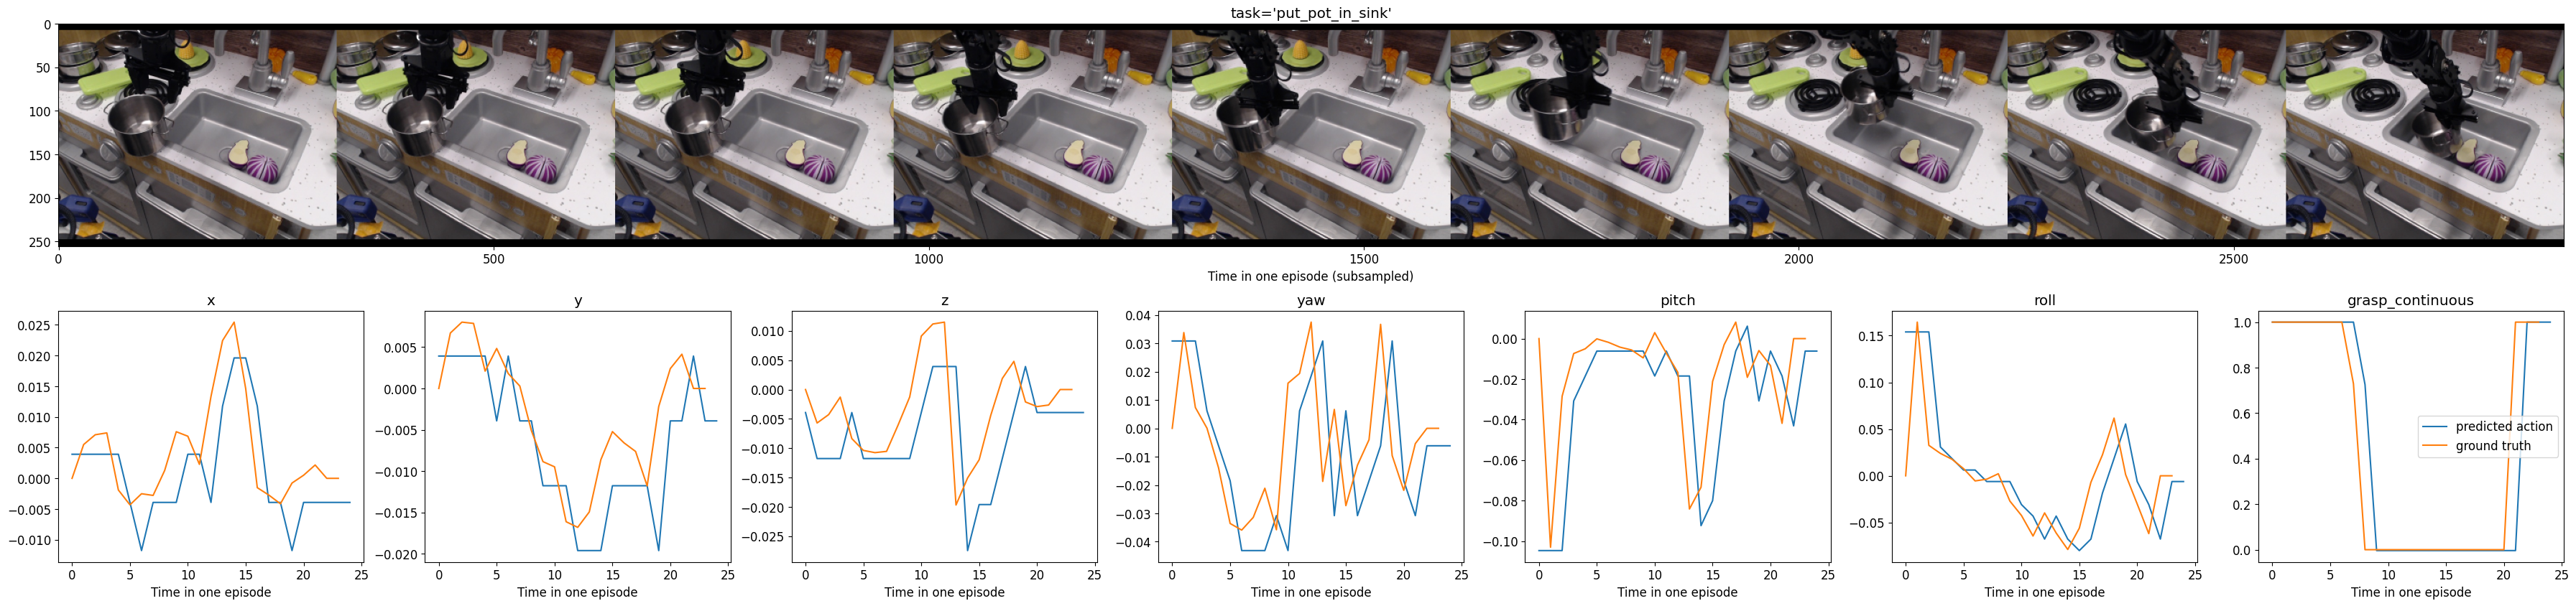

In [11]:
# Plot ground truth and predicted actions side by side 
# The predicted actions seem shifted forward by one timestep, but that should be fine for now.

action_order = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp_continuous']

figure_layout = [
    ['image'] * len(action_order),
    action_order
]

plt.rcParams.update({'font.size': 12})

stacked = tf.concat(tf.unstack(resized_images[::3], axis=0), 1)

# fig, axs = plt.subplots(1, len(action_name_to_values_over_time))
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

for action_dim, action_name in enumerate(action_order):
  axs[action_name].plot(predicted_actions_bridge_format[:, action_dim], label='predicted action')
  axs[action_name].plot(gt_actions[:, action_dim], label='ground truth')

  axs[action_name].set_title(action_name)
  axs[action_name].set_xlabel('Time in one episode')

axs['image'].imshow(stacked.numpy())
axs['image'].set_xlabel('Time in one episode (subsampled)')
axs['image'].set_title(f'{task=}')

plt.legend()


In [12]:
len(images), len(gt_actions), len(predicted_actions_bridge_format)

(25, 24, 25)